## Read in data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Tuple
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
data_df=pd.read_csv(r'WineQT.csv')

In [3]:
#we are interested in wine with quality values 5 and 6
data_df=data_df.loc[(data_df.quality==5)|(data_df.quality==6)].drop(columns='Id')


## Visualise the features of the two groups

In [5]:
average_data_df_features=data_df.drop(columns='quality')
average_data_df_features.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [15]:
def calc_normally_distributed_variables(data:pd.DataFrame, grouping_variable:int, target:str)->Tuple[list,list]:
    """Determine which features are normally distributed.
    
    Args:
        data: input dataframe with wine information
        grouping_variable: a variable to differentiate on between the groups
        target: name of the target column
    
    Returns: 
        Tuple[list, list]: the first list is of normally distributed features
                           the second list is of non-normally distributed features
     
    """
    group=data.loc[data[target]==grouping_variable]
    data=data.drop(columns=target)
    normally_distributed_variables=list()
    for col in data.columns:
            shapiro_test = stats.shapiro(group[col])
            if shapiro_test.pvalue <= 0.05:
                normally_distributed_variables.append(col)
    non_normally_distributed_variables=set(data.columns) - set(normally_distributed_variables)

    return normally_distributed_variables,non_normally_distributed_variables


def estimate_same_variance_variables(group_fair:list,group_alright:list, normality:bool, data:pd.DataFrame, target:str
)->Tuple[dict,dict]:
        """Determine which features have same and different variance.
    
        Args:
            group_fair: list of names of variables of group "fair"
            group_alright: list of names of variables of group "alright"
            normality: are we investigating normally or non-normally distributed features
            data: input dataframe with wine information
            target: name of the target column
        Returns: 
            Tuple[dict, dict]: the first list is of features with the same variance
                               the second list is of features with different variances

        """
        same_variance_dict=dict()
        not_same_variance_dict=dict()
        fair=data.loc[data[target]==6]
        alright=data.loc[data[target]==5]
        if normality==True:
            
            for col in list(set(group_fair).intersection(group_alright)):
                _, p = bartlett(alright[col], fair[col])
                if p>0.05:
                    same_variance_dict[col]=p
                else:
                    not_same_variance_dict[col]=p
        else:
            for col in list(set(group_fair).union(group_alright)):
                _, p = levene(alright[col], fair[col])
                if p>0.05:
                    same_variance_dict[col]=p
                #a very small p-value suggests that the populations do not have equal variances.
                else:
                    not_same_variance_dict[col]=p
        
        return same_variance_dict,not_same_variance_dict

In [8]:
#test data for normality

normally_distributed_variables_fair,non_normally_distributed_variables_fair=calc_normally_distributed_variables(data=data_df, grouping_variable=6, target='quality')
normally_distributed_variables_alright,non_normally_distributed_variables_alright=calc_normally_distributed_variables(data=data_df, grouping_variable=5, target='quality')


In [9]:
normally_distributed_variables_fair

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [10]:
non_normally_distributed_variables_fair

set()

In [11]:
normally_distributed_variables_alright

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'sulphates',
 'alcohol']

In [12]:
non_normally_distributed_variables_alright

{'pH'}

In [16]:

normal_same_variance_dict,normal_not_same_variance_dict=estimate_same_variance_variables(normally_distributed_variables_fair,normally_distributed_variables_alright, True,data_df,'quality')
non_normal_same_variance_dict,non_normal_not_same_variance_dict=estimate_same_variance_variables(non_normally_distributed_variables_fair,non_normally_distributed_variables_alright, False,data_df,'quality')



In [17]:
normal_same_variance_dict

{'sulphates': 0.750800224710428,
 'volatile acidity': 0.25648362107461176,
 'citric acid': 0.06964209452616645}

In [18]:
normal_not_same_variance_dict

{'chlorides': 3.0900043620550144e-08,
 'density': 1.3232640111812429e-05,
 'free sulfur dioxide': 0.0023982226764014186,
 'fixed acidity': 0.00527365230262844,
 'total sulfur dioxide': 2.8400885489636255e-17,
 'alcohol': 3.7362808577513587e-13,
 'residual sugar': 0.0036696758030806886}

In [19]:
non_normal_same_variance_dict

{'pH': 0.9241068801834686}

In [20]:
non_normal_not_same_variance_dict

{}

In [21]:
fair=data_df.loc[data_df.quality==6]
alright=data_df.loc[data_df.quality==5]

In [23]:
#matt whitney for non-parametric t test of independent means
#non normal, but same variance
test_results_MWT=dict()
for col in non_normal_same_variance_dict.keys():
    _, p_MWT = mannwhitneyu(alright[col], fair[col])
    test_results_MWT[col]=p_MWT 
test_results_MWT=pd.DataFrame.from_dict(test_results_MWT, orient='index')
test_results_MWT=test_results_MWT.reset_index().rename(columns={0:'p_value','index':'feature'})
test_results_MWT

,feature,p_value
0,pH,0.035209


In [25]:
#not same variance and normally distributed: use Welch's t test for comparison
_, p_WT = stats.ttest_ind(alright[list(normal_not_same_variance_dict.keys())], fair[list(normal_not_same_variance_dict.keys())], equal_var=False)
test_results_WT=pd.DataFrame(data={'feature':list(normal_not_same_variance_dict.keys()),'p_value':p_WT})
test_results_WT

,feature,p_value
0,chlorides,3.280101e-02
1,density,1.105157e-04
2,free sulfur dioxide,3.648400e-02
3,fixed acidity,1.498613e-01
4,total sulfur dioxide,7.462163e-14
5,alcohol,2.197012e-33
6,residual sugar,2.754747e-01


In [26]:
#same variance and normally distributed: use independent t test for comparison
_, p_IND = stats.ttest_ind(alright[list(normal_same_variance_dict.keys())], fair[list(normal_same_variance_dict.keys())], equal_var=True)
test_results_IND=pd.DataFrame(data={'feature':list(normal_same_variance_dict.keys()),'p_value':p_IND})
test_results_IND

,feature,p_value
0,sulphates,3.054234e-09
1,volatile acidity,1.255344e-13
2,citric acid,5.387698e-02


In [28]:
#diff variance and non normally distributed: use Yuen Welchs test
_, p_YWT = stats.ttest_ind(alright[list(non_normal_not_same_variance_dict.keys())], fair[list(non_normal_not_same_variance_dict.keys())], equal_var=False, trim=0.1)
test_results_YWT=pd.DataFrame(data={'feature':list(non_normal_not_same_variance_dict.keys()),'p_value':p_YWT})
test_results_YWT

,feature,p_value


In [29]:
non_normal_not_same_variance_dict

{}

In [32]:
#correct the test results due to multiple comparisons using Bonferroni correction
test_results_correct=pd.concat([test_results_WT,test_results_IND], ignore_index=True)
test_results_correct=pd.concat([test_results_correct,test_results_MWT], ignore_index=True)

test_results_correct=test_results_correct.sort_values(by='feature')
test_results_correct['p_adjusted'] = multipletests(test_results_correct.p_value, method='bonferroni')[1]
test_results_correct.loc[test_results_correct.p_adjusted>0.05,'significance']=False
test_results_correct.loc[test_results_correct.p_adjusted<=0.05,'significance']=True


In [33]:
test_results_correct

,feature,p_value,p_adjusted,significance
5,alcohol,2.197012e-33,2.416713e-32,True
0,chlorides,3.280101e-02,3.608111e-01,False
9,citric acid,5.387698e-02,5.926468e-01,False
1,density,1.105157e-04,1.215673e-03,True
3,fixed acidity,1.498613e-01,1.000000e+00,False
2,free sulfur dioxide,3.648400e-02,4.013240e-01,False
10,pH,3.520941e-02,3.873035e-01,False
6,residual sugar,2.754747e-01,1.000000e+00,False
7,sulphates,3.054234e-09,3.359658e-08,True
4,total sulfur dioxide,7.462163e-14,8.208379e-13,True


In [34]:
alright=alright.drop(columns='quality')
fair=fair.drop(columns='quality')

In [37]:
#what if a wrong test is used
#matt whitney for non-parametric t test of independent means
full_sample_test_results_MWT=dict()
for col in list(average_data_df_features.columns):
    if col!='output':
        _, p_MWT = mannwhitneyu(alright[col], fair[col])
        full_sample_test_results_MWT[col]=p_MWT 
full_sample_test_results_MWT=pd.DataFrame.from_dict(full_sample_test_results_MWT, orient='index')
full_sample_test_results_MWT=full_sample_test_results_MWT.reset_index().rename(columns={0:'p_value','index':'feature'})
full_sample_test_results_MWT['p_adjusted'] = multipletests(full_sample_test_results_MWT.p_value, method='bonferroni')[1]
full_sample_test_results_MWT.loc[full_sample_test_results_MWT.p_adjusted>0.05,'significance']=False
full_sample_test_results_MWT.loc[full_sample_test_results_MWT.p_adjusted<=0.05,'significance']=True
full_sample_test_results_MWT.sort_values(by='feature')  



,feature,p_value,p_adjusted,significance
10,alcohol,1.750347e-33,1.925382e-32,True
4,chlorides,2.201052e-05,2.421157e-04,True
2,citric acid,7.515839e-02,8.267422e-01,False
7,density,1.460483e-04,1.606531e-03,True
0,fixed acidity,5.388902e-01,1.000000e+00,False
5,free sulfur dioxide,1.299649e-01,1.000000e+00,False
8,pH,3.520941e-02,3.873035e-01,False
3,residual sugar,7.376520e-01,1.000000e+00,False
9,sulphates,3.544100e-20,3.898510e-19,True
6,total sulfur dioxide,4.929519e-09,5.422471e-08,True


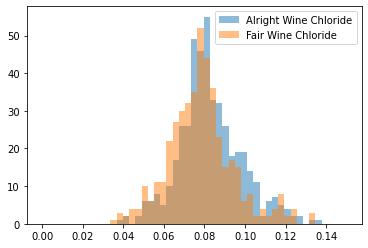

In [54]:
from matplotlib import pyplot


bins = np.linspace(0, 0.15, 50)

pyplot.hist(alright['chlorides'], bins, alpha=0.5, label='Alright Wine Chloride')
pyplot.hist(fair['chlorides'], bins, alpha=0.5, label='Fair Wine Chloride')
pyplot.legend(loc='upper right')
pyplot.show()